In the first blog post I used Keras to implement the Digit Recognizer. Pytorch is another great framework I want to try out, so here is the Digit Recognizer from the last post implemented with Pytorch.

The first part for importing the images we can take over from the first project:
(As a little improvement I use the reshape in the __load_mnist__ function now, so I can skip the two reshape lines later on).

In [21]:
import os
import gzip
import numpy as np
import struct
import urllib.request

def download_mnist(url, filename):
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, filename)
        print(f"Download complete.")

# Download the dataset
mnist_url = "http://yann.lecun.com/exdb/mnist/"
train_images = "train-images-idx3-ubyte.gz"
train_labels = "train-labels-idx1-ubyte.gz"
test_images = "t10k-images-idx3-ubyte.gz"
test_labels = "t10k-labels-idx1-ubyte.gz"

download_mnist(mnist_url + train_images, train_images)
download_mnist(mnist_url + train_labels, train_labels)
download_mnist(mnist_url + test_images, test_images)
download_mnist(mnist_url + test_labels, test_labels)

# Import the dataset
def load_mnist(images_path, labels_path):
    with gzip.open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8)

    with gzip.open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.frombuffer(imgpath.read(), dtype=np.uint8).reshape(len(labels), 1, 28, 28)

    return images, labels

X_train, y_train = load_mnist("train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz")
X_test, y_test = load_mnist("t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz")

Now we come to the first difference: The data is converted to PyTorch tensors so we can use it with the PyTorch framework.

I specify the types, as being explicit about the data type helps prevent bugs and ensures that the tensors are compatible with other PyTorch functionalities.

Here I use "float32" for the images, as most neural network frameworks use 32-bit floating point numbers for the weights and computations to balance computational efficiency with precision. Therefore, input data is often converted to float32 as well. Some hardware accelerators are optimized for float32 arithmetic and might be less efficient if other data types are used.

Then I use _long_ for the labels, because if I am using a loss function that expects class labels as integers (like Cross-Entropy Loss), the labels must be of type _long_. If they are not of type _long_, PyTorch will throw an error.

Afterwards I use "TensorDataset" to wrap the tensors in a dataset object. This dataset object is then passed to a data loader to create an iterable over the dataset, which is usually used if you have multiple arrays you want to access in pairs.

The "DataLoader" object helps manage batching, shuffling, and other dataset iteration functions that can be cumbersome to implement manually.

In [22]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# DataLoader
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

Next we define the device, preferably the GPU with the CPU as a fallback (the easy GPU/CPU switch is a nice feature of Pytorch; transferring our model and data between CPU and GPU in PyTorch is as simple as .to(device), making it convenient for optimizing computational resources).

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Now we come to the model structure. A warning beforehand: Keras is designed to be user-friendly, modular, and easy to extend, whereas PyTorch is designed to be flexible and expressive, offering more control, but it's structure is not as intuitive as Keras.

In Keras layers are defined and connected in a single flow and the forward pass is implicitly defined by how we connect layers. In PyTorch layers are defined in the __init__ method but are not connected and the forward pass is explicitly defined in the __forward__ method.

As PyTorch is more object-oriented than Keras, the model is defined as a class. Generally, a class allows me to encapsulate data and functions that operate on that data within a single entity.

In __init__ we therefore first define all layers and their structures and in __forward__ we then only have to put these layers in the correct order and only need a single input. I personally find this structuring clearer than with Keras.

Only torch.flatten still needs an additional input. Why? Let's have a look at the documentation:<br> _torch.flatten(input, start_dim=0, end_dim=-1)_.<br> 
In Deep Learning we often work with batches, for example if we have 32 greyscale (channels = 1) images with the dimensions 28x28 pixels, then the input tensor has the shape [32,1,28,28]
When flattening, you usually want to maintain this batch dimension and flatten only the other dimensions. This is what the _start_dim_ argument allows us to do. For example, setting _start_dim=1_ will keep the batch dimension intact and flatten all the other dimensions.

Then [32,1,28,28] becomes [32, 1⋅28⋅28] = [32, 784]. Therefore we set _start_dim=1_ here.

Also I added dropout layers, which help in preventing overfitting and are usually beneficial in larger models. Common dropout rates lie between 0.2 and 0.5. A rate of 0.5 means that approximately half of the input units will be dropped out during training. Higher dropout rates (0.4,0.5) are often used for layers that have more parameters to prevent overfitting. Lower rates (0.1,0.2) are used for layers with fewer parameters.

The first dropout layer has a rate of 0.25, which is a moderate dropout rate often used after convolutional layers. This helps to prevent overfitting while not being too aggressive in dropping out neurons, as convolutional layers are generally less prone to overfitting compared to fully connected layers.

The second dropout layer has a rate of 0.5, which is a common choice for dropout rates in fully connected layers. This is more aggressive and is intended to prevent overfitting in the more parameter-heavy fully connected layers.

Lastly, you can see that the softmax function also has an additional input. The _dim_ argument in the softmax function specifies the dimension along which the softmax function will be applied. In the end we have a tensor of the size [batch_size,num_classes]. Setting _dim=1_ applies softmax across each row, giving us the class probabilities for each individual sample in the batch instead of applying softmax independently across each column.


In [24]:
import torch.nn as nn

class DigitModel(nn.Module):
    def __init__(self):
        super(DigitModel, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        
        # Activation layers
        self.relu = nn.ReLU()
        
        # Pooling layers
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        # Dropout layers
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(1600, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        
        x = self.dropout1(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        
        x = self.dropout2(x)
        
        x = self.fc2(x)
        
        return nn.functional.log_softmax(x, dim=1)


The next step is the implementation of the training loop. Here we choose the same loss and optimizer settings as in the Keras code. Keras has provided us with some information about the process during the training. To get the same information here, we have to help ourselves a little bit. We implement this among other things with the module __tqdm__ for the progress bar (or rather __tqdm.notebook__, so that it looks nicer in Jupyter Notebook and doesn't take up so much space).

In [28]:
import torch.optim as optim
from tqdm.notebook import tqdm

# model = DigitModel()
model = DigitModel().to(device)

# Define the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 20

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    
    # Initialize a progress bar for training
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False) as pbar:
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate the loss and number of correct predictions
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

            pbar.update()
            pbar.set_postfix({'Loss': running_loss / (i + 1), 'Acc': correct_predictions 
                              / ((i + 1) * train_loader.batch_size)})

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    
    # Initialize a progress bar for validation
    with tqdm(total=len(test_loader), desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False) as pbar:
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()

                pbar.update()
                pbar.set_postfix({'Val Loss': val_loss / len(test_loader), 'Val Acc': val_correct 
                                  / len(test_loader.dataset)})

    print(f'Epoch {epoch+1}/{num_epochs} | '
      f'Train Loss: {running_loss / len(train_loader):.4f}, '
      f'Train Acc: {correct_predictions / len(train_loader.dataset):.4f} | '
      f'Val Loss: {val_loss / len(test_loader):.4f}, '
      f'Val Acc: {val_correct / len(test_loader.dataset):.4f}')
print('-' * 10)
print('Finished Training')

# Testing
correct = 0
total = 0
predicted_classes = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_classes.extend(predicted.cpu().numpy())
        
print('Accuracy of the network on test images: %.2f %%' % (100 * correct / total))

Epoch 1/20 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1/20 [Validation]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.5860, Train Acc: 0.8229 | Val Loss: 0.0812, Val Acc: 0.9764


Epoch 2/20 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2/20 [Validation]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.2357, Train Acc: 0.9281 | Val Loss: 0.0685, Val Acc: 0.9816


Epoch 3/20 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3/20 [Validation]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.1835, Train Acc: 0.9438 | Val Loss: 0.0489, Val Acc: 0.9858


Epoch 4/20 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4/20 [Validation]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.1535, Train Acc: 0.9534 | Val Loss: 0.0462, Val Acc: 0.9855


Epoch 5/20 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5/20 [Validation]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.1418, Train Acc: 0.9584 | Val Loss: 0.0592, Val Acc: 0.9849


Epoch 6/20 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6/20 [Validation]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.1283, Train Acc: 0.9623 | Val Loss: 0.0443, Val Acc: 0.9869


Epoch 7/20 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7/20 [Validation]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.1190, Train Acc: 0.9650 | Val Loss: 0.0475, Val Acc: 0.9863


Epoch 8/20 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8/20 [Validation]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.1094, Train Acc: 0.9678 | Val Loss: 0.0403, Val Acc: 0.9886


Epoch 9/20 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9/20 [Validation]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.1078, Train Acc: 0.9687 | Val Loss: 0.0384, Val Acc: 0.9891


Epoch 10/20 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10/20 [Validation]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.0982, Train Acc: 0.9717 | Val Loss: 0.0391, Val Acc: 0.9892


Epoch 11/20 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 11/20 [Validation]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.0938, Train Acc: 0.9723 | Val Loss: 0.0372, Val Acc: 0.9891


Epoch 12/20 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 12/20 [Validation]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.0904, Train Acc: 0.9738 | Val Loss: 0.0356, Val Acc: 0.9904


Epoch 13/20 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 13/20 [Validation]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.0856, Train Acc: 0.9748 | Val Loss: 0.0480, Val Acc: 0.9877


Epoch 14/20 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 14/20 [Validation]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.0794, Train Acc: 0.9774 | Val Loss: 0.0437, Val Acc: 0.9908


Epoch 15/20 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 15/20 [Validation]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.0866, Train Acc: 0.9749 | Val Loss: 0.0348, Val Acc: 0.9905


Epoch 16/20 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 16/20 [Validation]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.0806, Train Acc: 0.9770 | Val Loss: 0.0444, Val Acc: 0.9898


Epoch 17/20 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 17/20 [Validation]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.0821, Train Acc: 0.9765 | Val Loss: 0.0407, Val Acc: 0.9891


Epoch 18/20 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 18/20 [Validation]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.0806, Train Acc: 0.9767 | Val Loss: 0.0368, Val Acc: 0.9899


Epoch 19/20 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 19/20 [Validation]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.0804, Train Acc: 0.9778 | Val Loss: 0.0390, Val Acc: 0.9904


Epoch 20/20 [Train]:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 20/20 [Validation]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.0753, Train Acc: 0.9779 | Val Loss: 0.0371, Val Acc: 0.9901
----------
Finished Training
Accuracy of the network on test images: 99.01 %


The first thing that catches the eye is that validation loss and accuracy are always better than training loss and accuracy. This is somewhat counterintuitive, but can result from the dropout during training, which randomly sets a fraction of the input units to 0 at each forward pass. This is a form of regularization and can make the network appear to perform worse during training. During evaluation, dropout is deactivated, so the model uses all the learned features, often resulting in better performance.

We also see that the validation accuracy is already better after the first epoch than in the Keras model after 20 epochs, which may also be due to the dropout. In the end we have a test accuracy of over 99%, a 3% increase in comparison to the last blog post!

I have to say that PyTorch convinces me more than Keras. Apart from the fact that PyTorch seems to prevail over Keras (and TensorFlow too?) especially in scientific applications, I like the model structure better. Also, there seems to be a better ecosystem for PyTorch than for Keras, which includes specialized libraries for various tasks (e.g., torchvision for computer vision, torchaudio for audio tasks, torchtext for text-based applications). There are certainly many other differences, but these are the important ones for me for now, so I will stick with PyTorch.

Lastly I am addding the plot of wrongly determined numbers as in the last blog post.

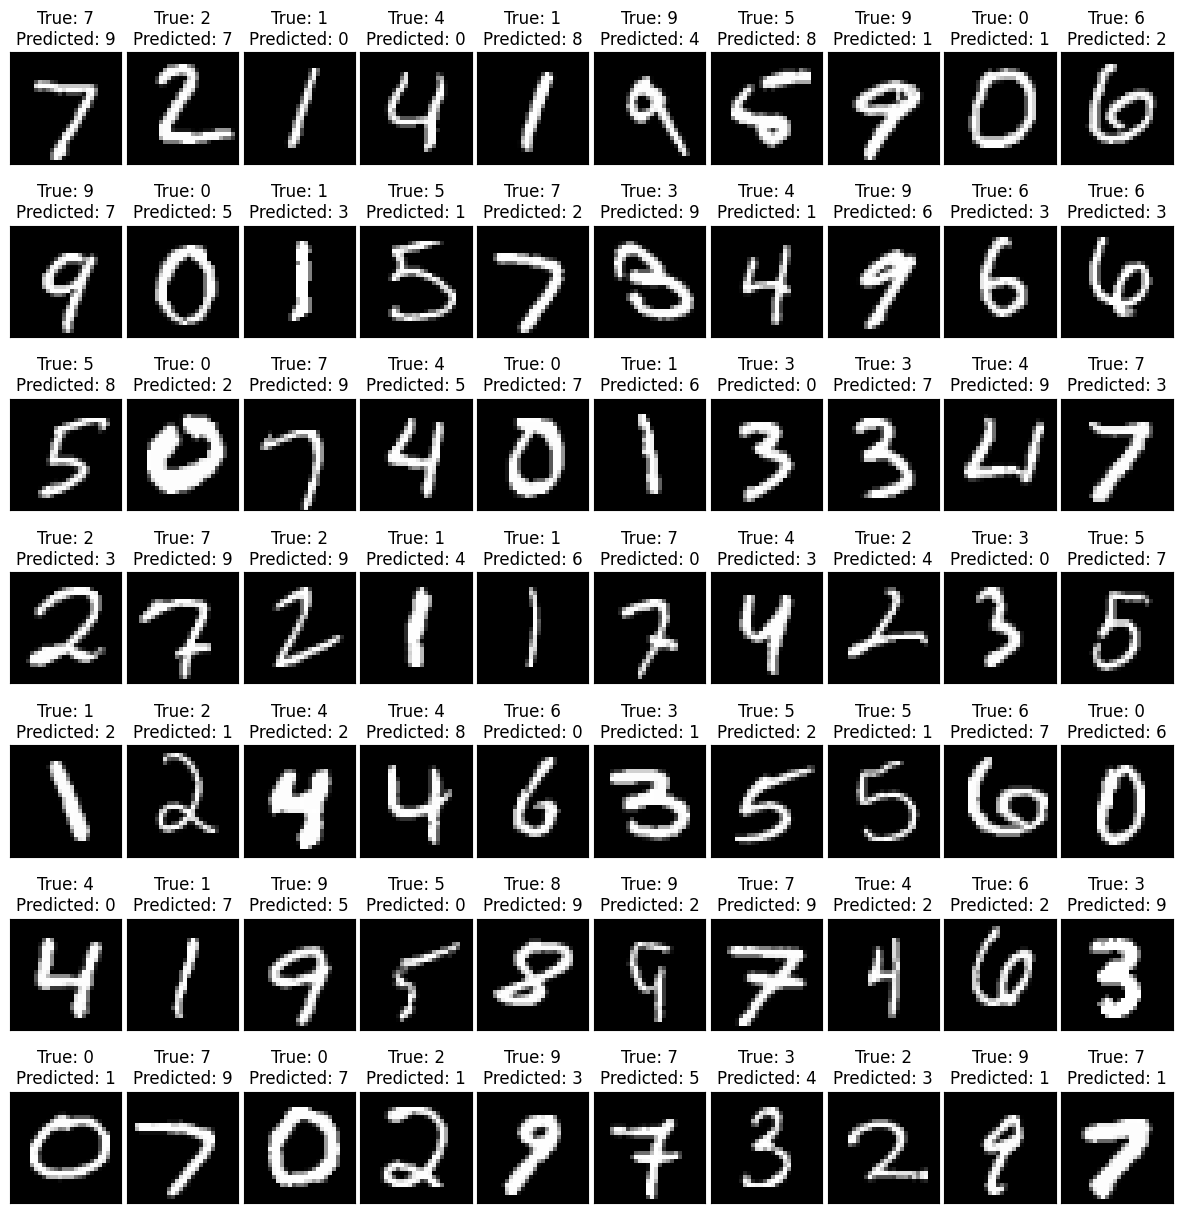

In [29]:
import matplotlib.pyplot as plt

predicted_classes = np.array(predicted_classes)

# Set a threshold for the prediction uncertainty
uncertainty_threshold = 0.9

# Get the indices of the samples with prediction uncertainty above the threshold
uncertain_indices = np.where(np.max(predicted.cpu().numpy()) < uncertainty_threshold)[0]
# uncertain_indices = np.where(np.max(predicted_classes) < uncertainty_threshold)[0]

num_images = 70

wrong_indices = [i for i, prediction in enumerate(predicted_classes) if prediction != y_test[i]]
rows = num_images // 10 + (num_images % 10 != 0)
fig, axs = plt.subplots(rows, 10, figsize=(15, 15), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.5, wspace=0.05)
axs = axs.ravel()
for i, index in enumerate(wrong_indices[:num_images]):
    axs[i].imshow(X_test[index].reshape(28, 28), cmap="gray")
    axs[i].set_title("True: {}\nPredicted: {}".format(y_test[index], predicted_classes[index]))
for i in range(num_images, rows * 10):
    fig.delaxes(axs[i])
plt.show()